In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image

# PARAMETERS
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_INITIAL = 10
NUM_EPOCHS_FINETUNE = 5
DATA_PATH = "Aeroplane-Ai/DataSet"

# STEP 1: DATA PREPARATION & AUGMENTATION
# ---------------------------------------
# We'll split the data into training and validation sets using ImageDataGenerator's built-in splitting.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2  # 20% validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

num_classes = len(train_generator.class_indices)
print("Number of Classes:", num_classes)

Found 1752 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Number of Classes: 3


In [2]:
# STEP 2: LOAD THE PRETRAINED MODEL & BUILD A CUSTOM HEAD
# ---------------------------------------------------------
# The base model (EfficientNetB3) processes images and extracts meaningful features like edges, textures, and object shapes.
# EfficientNetB3 is already optimized, so it saves time and boosts accuracy.
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# The custom head takes those features and classifies them into specific airplane models.
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensionality while keeping essential features.
x = Dense(256, activation='relu')(x) # Adds a fully connected layer to learn from extracted features.
x = Dropout(0.5)(x) # Prevents overfitting by randomly disabling 50% of neurons during training.
predictions = Dense(num_classes, activation='softmax')(x) # Final classification layer for aircraft types.

# Combine the base model and the new head into a final model
model = Model(inputs=base_model.input, outputs=predictions)

In [3]:
# STEP 3: COMPILE THE MODEL
# ---------------------------
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,177,778 (42.64 MB)

 Trainable params: 11,090,475 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [4]:
# STEP 4: INITIAL TRAINING
# --------------------------
# Train only the custom head; the base model remains frozen.

# CALLBACKS: Learning Rate Reduction & Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_INITIAL,
    validation_data=validation_generator
)

C:\Users\dawny\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.4742 - loss: 0.9988 - val_accuracy: 0.0915 - val_loss: 1.2856
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.6448 - loss: 0.7276 - val_accuracy: 0.3547 - val_loss: 1.0352
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7640 - loss: 0.5091 - val_accuracy: 0.4188 - val_loss: 0.9735
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8438 - loss: 0.3820 - val_accuracy: 0.5515 - val_loss: 0.9685
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.8700 - loss: 0.3230 - val_accuracy: 0.5423 - val_loss: 1.1678
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9076 - loss: 0.2485 - val_accuracy: 0.5240 - val_loss: 1.1284
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9102 - loss: 0.2186 - val_accuracy: 0.5217 - val_loss: 1.1169
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9328 - loss: 0.1744 - val_accuracy: 0.5629 - v

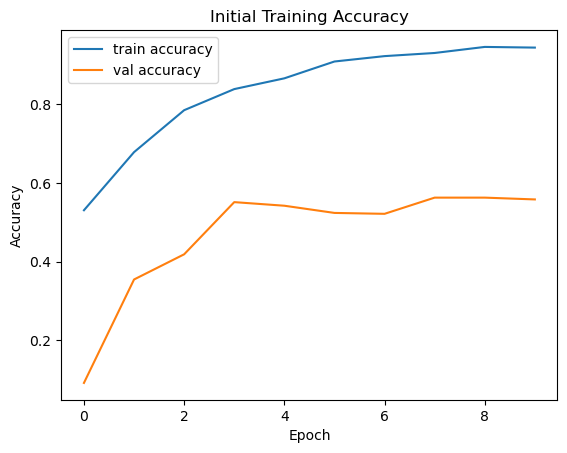

In [5]:
# Plot training history 
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model is learning well on the training data, as training accuracy steadily increases.
Validation accuracy initially improves but then stagnates and fluctuates, which may indicate overfitting starting to occur.
There is a significant gap between training and validation accuracy, suggesting the model may be memorizing the training data rather than generalizing well.

In [7]:
# STEP 5: FINE-TUNING THE MODEL 
# ------------------------------------------
# Unfreeze the top few layers of the base model for fine-tuning.
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_FINETUNE,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9509 - loss: 0.1247 - val_accuracy: 0.6339 - val_loss: 1.3701 - learning_rate: 1.0000e-05
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9520 - loss: 0.1212 - val_accuracy: 0.6842 - val_loss: 1.1628 - learning_rate: 1.0000e-05
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.9619 - loss: 0.1095 - val_accuracy: 0.7208 - val_loss: 0.8342 - learning_rate: 1.0000e-05
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.9517 - loss: 0.1224 - val_accuracy: 0.7391 - val_loss: 1.0090 - learning_rate: 1.0000e-05
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9604 - loss: 0.1005 - val_accuracy: 0.7300 - val_loss: 0.9735 - learning_rate: 1.0000e-05


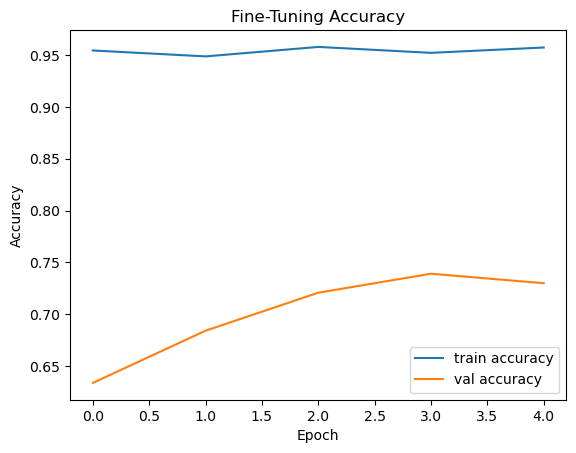

In [8]:
# Plot fine-tuning history 
plt.plot(history_finetune.history['accuracy'], label='train accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This suggests that while the model learns well on training data, validation accuracy improves over time but does not reach the same level as training accuracy. The small dip at the end could indicate early signs of overfitting.

In [10]:
# STEP 6: EVALUATE THE MODEL ON A TEST SET
# ------------------------------------------
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_PATH,  
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 2189 images belonging to 3 classes.
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 580ms/step - accuracy: 0.9293 - loss: 0.2176
Test Accuracy: 0.9095


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


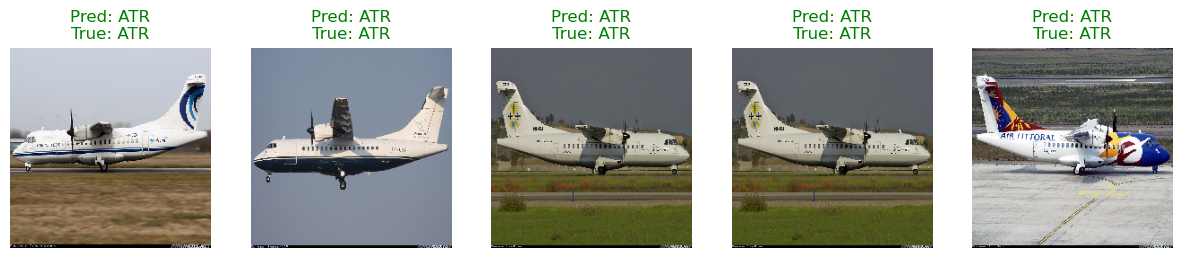

In [28]:
# Get some test images and corresponding true labels
test_images, test_labels = next(test_generator)  # Get a batch of test images

# Get model predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Define class names
class_names = list(test_generator.class_indices.keys())

# Display images with predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(test_images) - 1)  # Pick a random image from the batch
    img = test_images[idx]
    
    # Show the image
    ax.imshow(img)
    ax.axis("off")
    
    # Set title with prediction and true label
    pred_label = class_names[y_pred_classes[idx]]
    true_label = class_names[np.argmax(test_labels[idx])]
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=12, color=("green" if pred_label == true_label else "red"))

plt.show()

In [20]:
# Get raw probability outputs from the test generator
predictions = model.predict(test_generator)

# Convert probabilities to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class indices from the generator
true_class_indices = test_generator.classes

# Print class labels for better understanding
class_labels = list(test_generator.class_indices.keys())
print("\nClass Labels:")
for i, label in enumerate(class_labels):
    print(f"{i}: {label}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 45s 620ms/step

Class Labels:
0: ATR
1: Airbus
2: Boeing


In [31]:
# Get ground truth labels
true_labels = test_generator.classes  # Actual class indices
class_labels = list(test_generator.class_indices.keys())  # Class names

# Get model predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert to class indices

# Compute classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 558ms/step

Classification Report:
               precision    recall  f1-score   support

         ATR       0.99      0.98      0.99       200
      Airbus       0.90      0.94      0.92      1200
      Boeing       0.91      0.84      0.87       789

    accuracy                           0.91      2189
   macro avg       0.93      0.92      0.93      2189
weighted avg       0.91      0.91      0.91      2189



Overall, the classification model shows strong performance, especially for the ATR class, while also performing well for Airbus and Boeing, although there's some room for improvement, especially in the recall for the Boeing class.

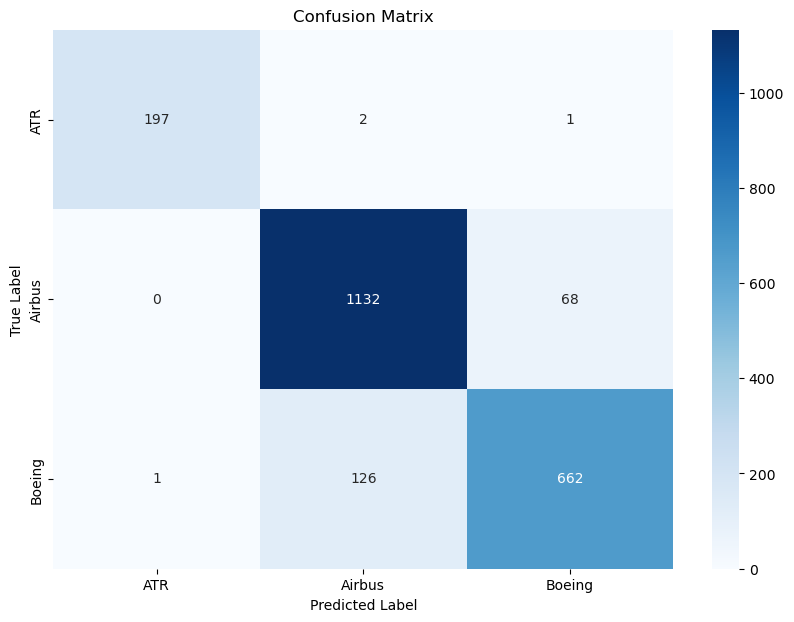

In [32]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The model performs well for ATR and Airbus classes, with a high number of true positives and very few false positives.
However, the Boeing class has a higher number of false negatives (126 instances misclassified), indicating that the model could improve in correctly identifying Boeing instances.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


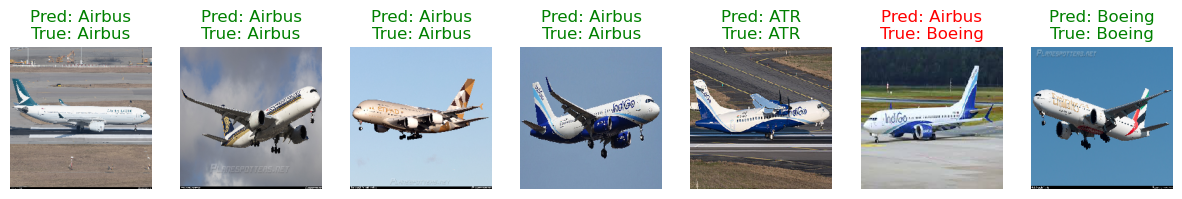

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array, img  # Return both preprocessed and original image

def predict_from_directory(directory_path):
    class_labels = {0: 'ATR', 1: 'Airbus', 2: 'Boeing'}  # Model's class mapping

    images = []  # Store images for display
    predictions_list = []  # Store predictions
    true_labels_list = []  # Store true labels

    for class_name in os.listdir(directory_path):  # Loop over Boeing, ATR, Airbus folders
        class_path = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_path):  # Skip non-directory files
            continue

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  
                img_path = os.path.join(class_path, filename)
                img_array, original_img = preprocess_image(img_path)

                # Predict
                predictions = model.predict(img_array)
                predicted_class_idx = np.argmax(predictions, axis=1)[0]
                predicted_label = class_labels[predicted_class_idx]

                # Get the true label from folder name
                true_label = class_name  

                images.append(original_img)
                predictions_list.append(predicted_label)
                true_labels_list.append(true_label)

    # Display images with predictions and true labels
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:  
        axes = [axes]  # Ensure iterable for a single image case

    for ax, img, pred_label, true_label in zip(axes, images, predictions_list, true_labels_list):
        ax.imshow(img)
        ax.axis("off")
        color = "green" if pred_label == true_label else "red"
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=12, color=color)

    plt.show()


directory_path = 'Aeroplane-Ai/test_images/'
predict_from_directory(directory_path)